## Enhance noisy grayscale document images using Unet & Fast.ai library

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg16_bn

In [2]:
os.getcwd()

'/home/ec2-user/SageMaker/dl1_2019-10-31'

#### We are using dataset from Kaggle competition - [Denoising Dirty Documents](https://www.kaggle.com/c/denoising-dirty-documents)
- Begin with creating a new folder, "denoise", under CWD and download and extract files
- Create dataset from files

In [3]:
path = Path(os.getcwd())/'denoise'
path_clean = path/'train_cleaned'
path_noisy = path/'train'
path_test = path/'test'

model_path = path/'model/model_final.pkl'

#### Split Data into train and validation set randomly in 90:10 ratio

In [4]:
src = ImageImageList.from_folder(path_noisy).split_by_rand_pct(0.1, seed=9)
print(src)

ItemLists;

Train: ImageImageList (130 items)
Image (3, 420, 540),Image (3, 420, 540),Image (3, 420, 540),Image (3, 420, 540),Image (3, 420, 540)
Path: /home/ec2-user/SageMaker/dl1_2019-10-31/denoise/train;

Valid: ImageImageList (14 items)
Image (3, 420, 540),Image (3, 258, 540),Image (3, 420, 540),Image (3, 420, 540),Image (3, 258, 540)
Path: /home/ec2-user/SageMaker/dl1_2019-10-31/denoise/train;

Test: None


In [5]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_clean/x.relative_to(path_noisy))
           .transform(get_transforms(max_zoom=1., do_flip=False), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(mnist_stats, do_y=True))
    data.c = 3
    return data

In [6]:
# for first iteration, lets experiment with 128X128 images
bs,size=16,128 
arch = models.resnet34

In [7]:
data = get_data(bs,size)

#### Let's look at some noisy and clean images side by side

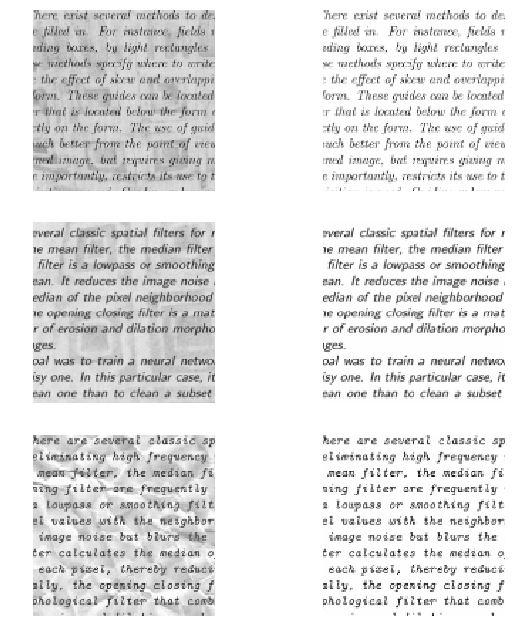

In [8]:
data.show_batch(ds_type=DatasetType.Valid, rows=3, figsize=(9,9))

## Creating Feature loss function
### using convolution layers in vgg16 for feature extraction and calculate loss

In [9]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [10]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [11]:
gram_matrix(t)

tensor([[[0.2845, 0.2845, 0.2845],
         [0.2845, 0.2845, 0.2845],
         [0.2845, 0.2845, 0.2845]],

        [[0.2845, 0.2845, 0.2845],
         [0.2845, 0.2845, 0.2845],
         [0.2845, 0.2845, 0.2845]]])

In [12]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [13]:
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [14]:
base_loss = F.l1_loss

In [15]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [16]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Lets train our model

In [17]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight)
gc.collect();

In [20]:
learn.freeze()

In [21]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
__________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


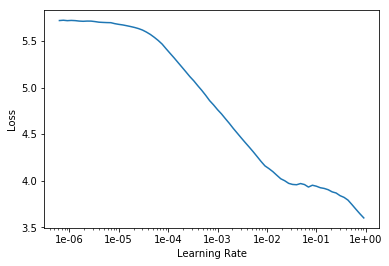

In [19]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-3

In [23]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.3, epoch=10):
    learn.fit_one_cycle(epoch, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,5.030048,3.858294,1.188250,0.271759,0.269801,0.076448,1.087369,0.907289,0.057378,00:12
1,4.121186,2.728460,0.468666,0.246746,0.220688,0.067629,1.004722,0.667780,0.052229,00:06
2,3.561346,2.413986,0.564109,0.218112,0.188499,0.057878,0.776978,0.554447,0.053964,00:06
3,3.230672,2.398950,0.544788,0.206231,0.190259,0.062715,0.775083,0.563174,0.056700,00:06
4,2.905796,1.620468,0.422213,0.179990,0.136729,0.029139,0.487493,0.346598,0.018306,00:06
5,2.626761,1.446349,0.396444,0.162440,0.126764,0.026200,0.406675,0.311980,0.015846,00:06
6,2.396303,1.311237,0.322295,0.155083,0.123920,0.024624,0.373803,0.297705,0.013808,00:06
7,2.167383,1.154345,0.296979,0.153064,0.109198,0.020107,0.327939,0.236610,0.010448,00:06
8,1.973678,1.043016,0.279432,0.144531,0.103629,0.017617,0.272852,0.216456,0.008499,00:06
9,1.813378,1.014969,0.267478,0.142763,0.101437,0.016682,0.268832,0.209915,0.007861,00:06


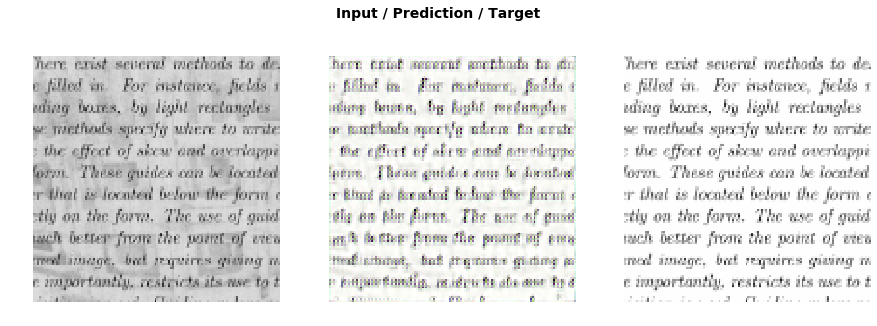

In [24]:
do_fit('iter1', slice(lr*10), epoch = 12)

In [25]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.047643,0.993505,0.272769,0.141985,0.099436,0.015677,0.253177,0.203348,0.007112,00:07
1,1.056046,0.971313,0.261424,0.140643,0.098634,0.016063,0.247082,0.200030,0.007437,00:06
2,1.052165,0.980625,0.269575,0.140803,0.098198,0.015318,0.249235,0.200644,0.006852,00:06
3,1.039728,0.996553,0.293991,0.138752,0.096463,0.015312,0.246066,0.198993,0.006976,00:06
4,1.033705,0.949352,0.258772,0.133555,0.097063,0.016582,0.239172,0.196205,0.008004,00:06
5,1.021192,0.937725,0.266947,0.133686,0.093957,0.014411,0.229890,0.192423,0.006410,00:06
6,0.996198,0.822478,0.212916,0.126849,0.089797,0.014471,0.197041,0.174632,0.006771,00:06
7,0.970442,0.820614,0.212539,0.123569,0.089099,0.015058,0.198233,0.174696,0.007420,00:06
8,0.957531,0.778797,0.191069,0.120345,0.086896,0.014865,0.189296,0.168974,0.007352,00:06
9,0.933372,0.760427,0.192593,0.119641,0.085205,0.013936,0.178008,0.164365,0.006679,00:06


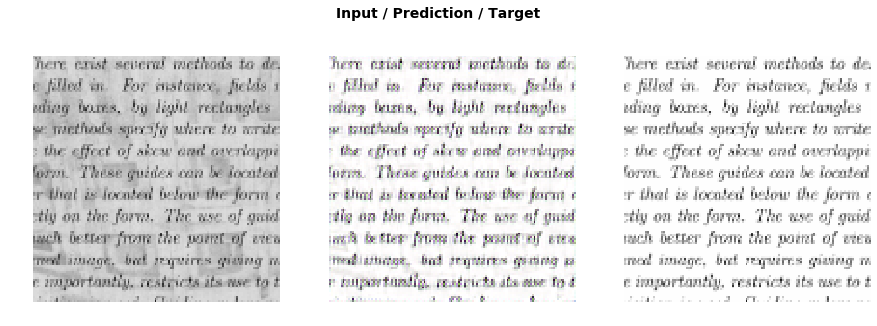

In [26]:
do_fit('iter2', slice(1e-5,lr), epoch = 15)

#### Experiement by increasing image size to 256 X 256 and retrain our model, keeping the existing learned weights.

In [27]:
bs,size= 16, 256
data = get_data(bs,size)

In [28]:
learn.data = data
learn.freeze()
gc.collect()

19481

In [29]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
__________________________________________________

In [30]:
learn.load('iter2')

Learner(data=ImageDataBunch;

Train: LabelList (130 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/ec2-user/SageMaker/dl1_2019-10-31/denoise/train;

Valid: LabelList (14 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/ec2-user/SageMaker/dl1_2019-10-31/denoise/train;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.980782,0.931455,0.153790,0.124516,0.097111,0.010589,0.363629,0.179097,0.002723,00:54
1,0.951591,0.828394,0.135187,0.114150,0.090508,0.009880,0.311254,0.164847,0.002569,00:19
2,0.903879,0.725289,0.127035,0.102443,0.080950,0.008661,0.259674,0.144308,0.002219,00:19
3,0.846509,0.628971,0.119530,0.092076,0.070957,0.006931,0.219170,0.118645,0.001662,00:19
4,0.788308,0.546196,0.108782,0.082592,0.062789,0.005620,0.184824,0.100339,0.001250,00:19
5,0.735041,0.535116,0.134114,0.077134,0.058680,0.005111,0.165772,0.093207,0.001098,00:19
6,0.689038,0.477327,0.107048,0.071234,0.054162,0.004637,0.152565,0.086697,0.000985,00:19
7,0.652551,0.460324,0.099154,0.070559,0.053882,0.004656,0.148423,0.082662,0.000987,00:19
8,0.619376,0.434658,0.092998,0.068226,0.051868,0.004335,0.136677,0.079663,0.000892,00:19
9,0.589506,0.436080,0.095205,0.068287,0.051824,0.004312,0.136454,0.079112,0.000886,00:19


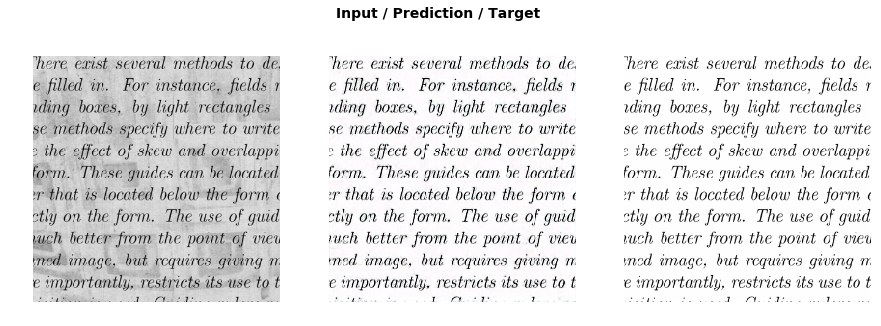

In [31]:
do_fit('iter2.1')

In [32]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.472915,0.430758,0.091803,0.068067,0.051590,0.004291,0.136139,0.077983,0.000885,00:21
1,0.463213,0.427489,0.092647,0.067245,0.050984,0.004261,0.133716,0.077755,0.000880,00:21
2,0.460264,0.422402,0.088918,0.066883,0.050613,0.004220,0.134810,0.076087,0.000871,00:21
3,0.459934,0.423745,0.091098,0.066395,0.050330,0.004204,0.134903,0.075952,0.000865,00:21
4,0.454355,0.402778,0.085526,0.064651,0.048881,0.004026,0.126077,0.072799,0.000819,00:21
5,0.451440,0.402729,0.089896,0.064165,0.048397,0.003944,0.123440,0.072093,0.000793,00:21
6,0.448856,0.399054,0.085818,0.064053,0.048303,0.003933,0.124798,0.071362,0.000787,00:21
7,0.444919,0.398047,0.086514,0.063594,0.048013,0.003934,0.123889,0.071307,0.000797,00:21
8,0.441910,0.394509,0.084882,0.063472,0.047849,0.003904,0.122974,0.070644,0.000785,00:21
9,0.439512,0.394387,0.085165,0.063475,0.047836,0.003899,0.122694,0.070536,0.000783,00:21


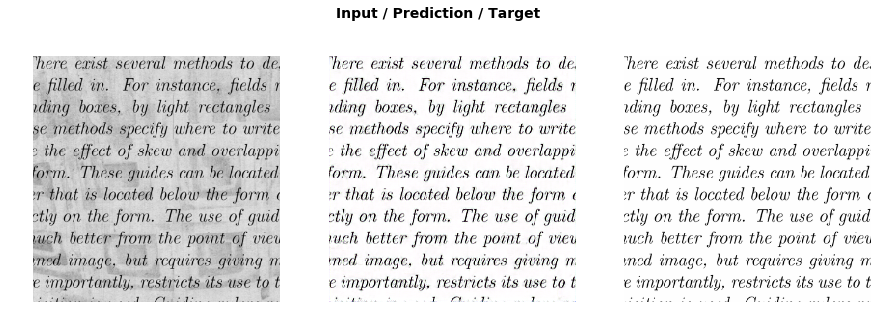

In [33]:
do_fit('iter2.2', slice(1e-6,1e-4), pct_start=0.3)

## Testing results on validation set

In [34]:
learn.load('iter2.2')

Learner(data=ImageDataBunch;

Train: LabelList (130 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/ec2-user/SageMaker/dl1_2019-10-31/denoise/train;

Valid: LabelList (14 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/ec2-user/SageMaker/dl1_2019-10-31/denoise/train;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride

In [35]:
fn = data.valid_ds.x.items[2]; fn

PosixPath('/home/ec2-user/SageMaker/dl1_2019-10-31/denoise/train/132.png')

In [36]:
img = open_image(fn); img.shape

torch.Size([3, 420, 540])

In [37]:
p,img_pred,b = learn.predict(img)

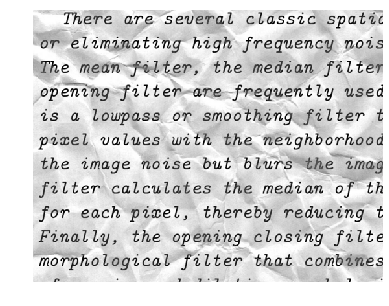

In [38]:
show_image(img, figsize=(8,5), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


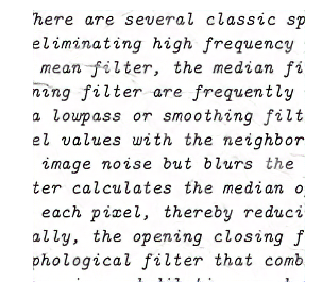

In [39]:
Image(img_pred).show(figsize=(8,5))

In [1]:
#learn.export(file = model_path)

## Testing results on test set

In [ ]:
# Turn off resizing transformations for inference time.
# https://forums.fast.ai/t/segmentation-mask-prediction-on-different-input-image-sizes/44389
learn.data.single_ds.tfmargs['size'] = None

In [ ]:
test_images = ImageImageList.from_folder(path_test)
print(test_images)

In [ ]:
img = test_images[1]
img.show()
img.shape

In [ ]:
p, img_pred, b = learn.predict(img)

In [ ]:
img_pred

In [ ]:
img_pred.size()

In [ ]:
Image(img_pred)

### As you can see that there are still some minor imperfections however we are able to enhance that image to large extent